# Detectron2

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

Welcome to detectron2! This is the official colab tutorial of detectron2. Here, we will go through some basics usage of detectron2, including the following:
* Run inference on images or videos, with an existing detectron2 model
* Train a detectron2 model on a new dataset

You can make a copy of this tutorial by "File -> Open in playground mode" and make changes there. __DO NOT__ request access to this tutorial.


# Install detectron2

In [1]:
# !pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
# !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtimeInitializing libiomp5md.dll, but found libiomp5md.dll already initialized.
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"



torch:  1.12 ; cuda:  cu113


In [2]:
# Some basic setup:
# Setup detectron2 logger
import matplotlib.pyplot as plt
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog, build_detection_train_loader
from detectron2.data.datasets import register_coco_instances
from detectron2.data.dataset_mapper import DatasetMapper
from detectron2.data import transforms as T

from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.utils.visualizer import ColorMode
from detectron2.engine import DefaultTrainer


In [3]:
torch.cuda.is_available()

True

# Inference COCO dataset

In [4]:
img_folder = "dataset/imgs_png"

train_coco_json_pth = "dataset/train.json"
train_dataset_name = "train_dataset"

val_coco_json_pth = "dataset/val.json"
val_dataset_name = "val_dataset"

try:
    register_coco_instances(train_dataset_name, {}, train_coco_json_pth, img_folder)
except AssertionError:
    pass

try:
    register_coco_instances(val_dataset_name, {}, val_coco_json_pth, img_folder)
except AssertionError:
    pass

In [5]:
wagon_metadata = MetadataCatalog.get(train_dataset_name)
dataset_dicts = DatasetCatalog.get(train_dataset_name)

[09/11 01:31:46 d2.data.datasets.coco]: Loaded 180 images in COCO format from dataset/train.json


To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



[09/11 01:31:46 d2.data.datasets.coco]: Loaded 180 images in COCO format from dataset/train.json
[09/11 01:31:46 d2.data.datasets.coco]: Loaded 180 images in COCO format from dataset/train.json
[09/11 01:31:47 d2.data.datasets.coco]: Loaded 180 images in COCO format from dataset/train.json


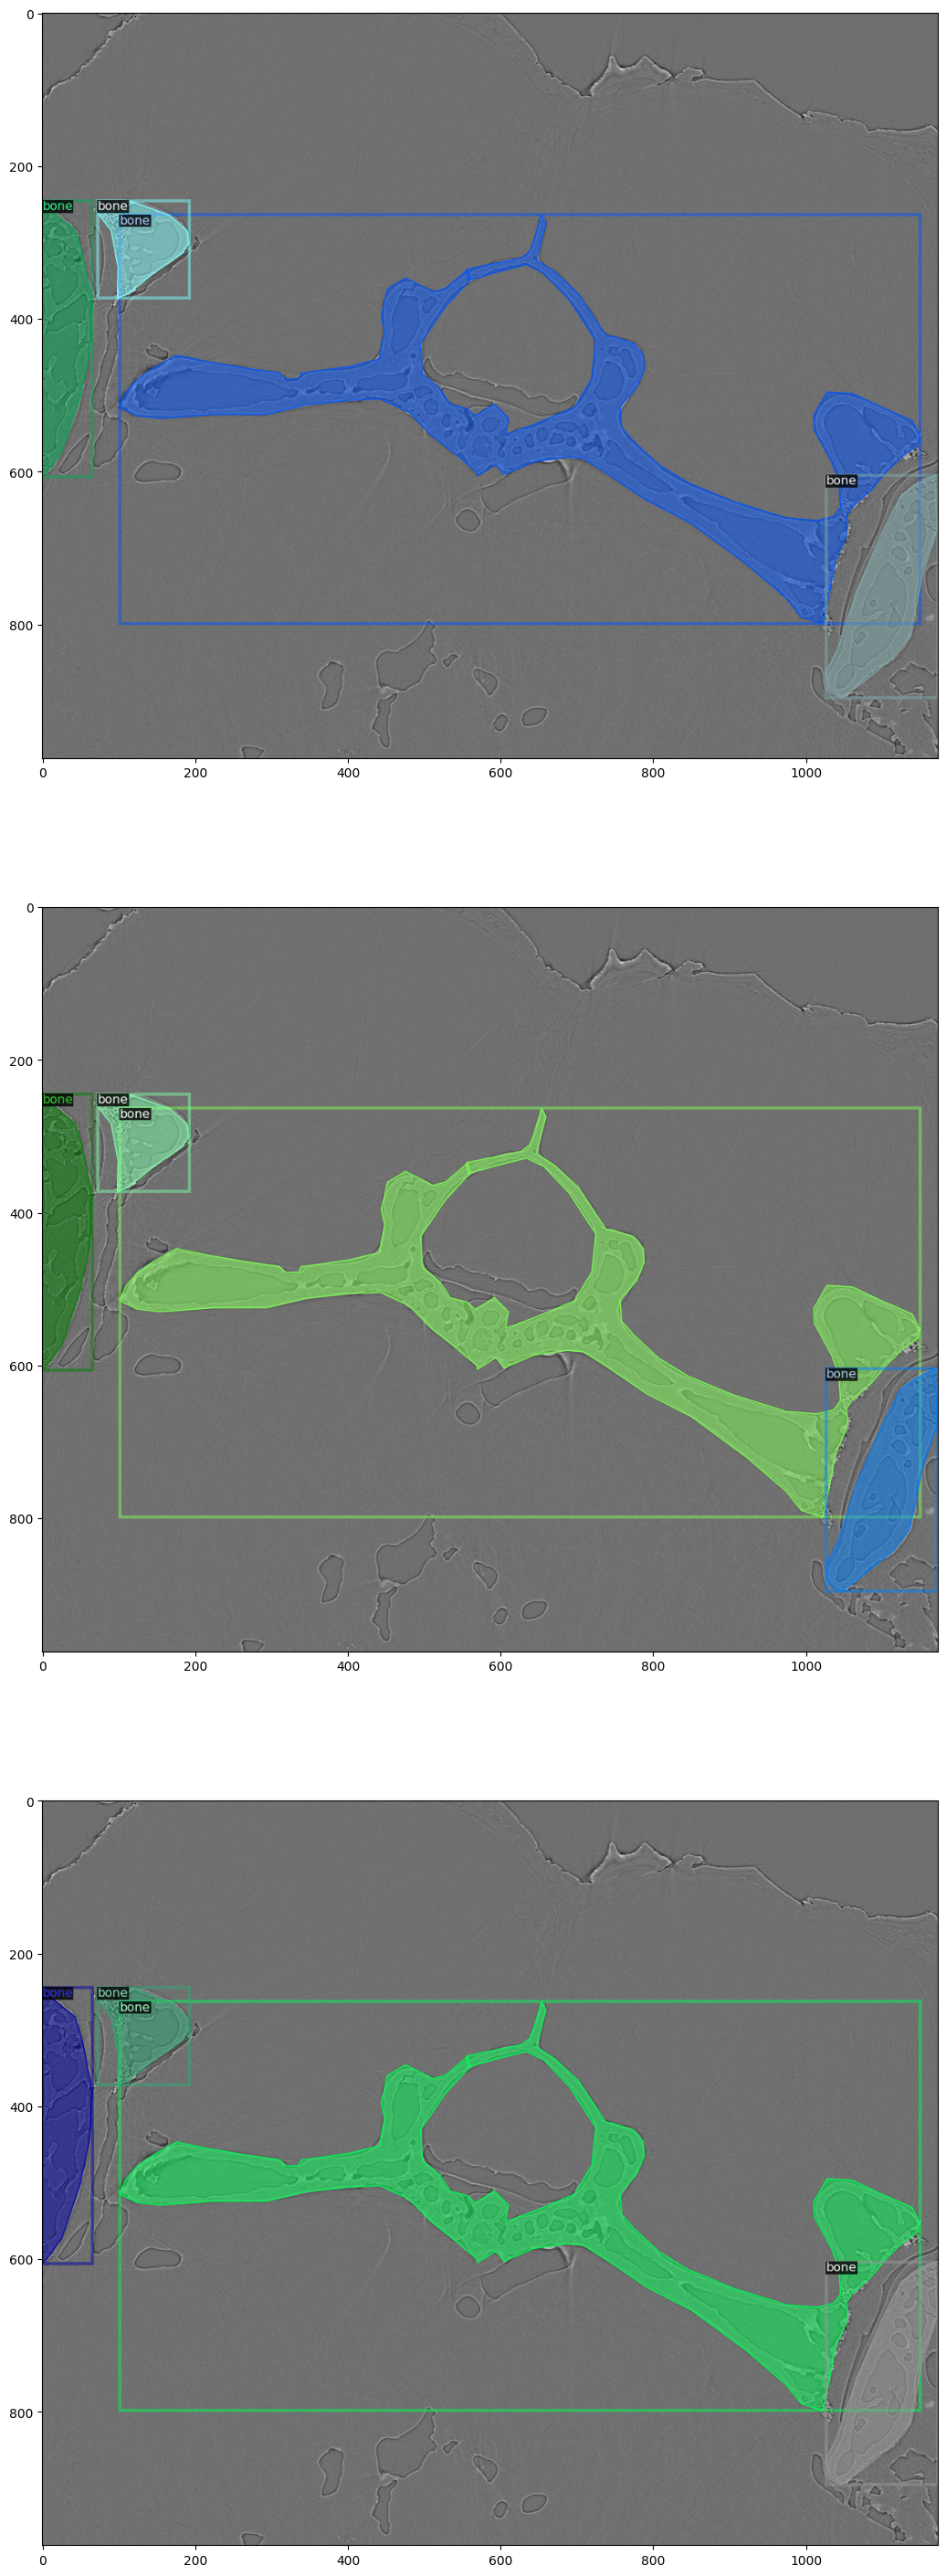

In [6]:
count_imges_to_display = 3
fig, axes = plt.subplots(nrows=count_imges_to_display, figsize=(16, 36))

# dataset_dicts = get_dataset_dicts(f"{dataset_root_folder}/dataset/train")
for d, ax in zip(random.sample(dataset_dicts, count_imges_to_display), axes):
    d = DatasetCatalog.get(train_dataset_name)[0]
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=wagon_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    ax.imshow(out.get_image()[:, :, ::-1])

## Train!

Now, let's fine-tune a COCO-pretrained R50-FPN Mask R-CNN model on the balloon dataset. It takes ~2 minutes to train 300 iterations on a P100 GPU.


In [7]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = (train_dataset_name,)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.001 # pick a good LR
cfg.SOLVER.MAX_ITER = 500    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(wagon_metadata.thing_classes)  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.
cfg.OUTPUT_DIR = "models/model_final.pth"

In [8]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

aug = [T.RandomBrightness(0.9, 1.1),
       T.RandomFlip(prob=0.5),
       T.RandomCrop("absolute", (640, 640))]

class MyTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        mapper = DatasetMapper(cfg, is_train=True, augmentations=aug)
        return build_detection_train_loader(cfg, mapper=mapper)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[09/11 01:31:49 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[09/11 01:31:50 d2.engine.train_loop]: Starting training from iteration 0


c:\Users\ankha\anaconda3\envs\detectron2\lib\site-packages\torch\functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[09/11 01:32:08 d2.utils.events]:  eta: 0:04:58  iter: 19  total_loss: 2.394  loss_cls: 0.6457  loss_box_reg: 0.9083  loss_mask: 0.6863  loss_rpn_cls: 0.09377  loss_rpn_loc: 0.03024  time: 0.6299  data_time: 0.1848  lr: 3.8962e-05  max_mem: 2179M
[09/11 01:32:21 d2.utils.events]:  eta: 0:05:01  iter: 39  total_loss: 2.07  loss_cls: 0.4966  loss_box_reg: 0.8996  loss_mask: 0.6318  loss_rpn_cls: 0.02373  loss_rpn_loc: 0.02558  time: 0.6404  data_time: 0.0015  lr: 7.8922e-05  max_mem: 2179M
[09/11 01:32:35 d2.utils.events]:  eta: 0:04:49  iter: 59  total_loss: 1.867  loss_cls: 0.4132  loss_box_reg: 0.8813  loss_mask: 0.515  loss_rpn_cls: 0.01155  loss_rpn_loc: 0.02309  time: 0.6530  data_time: 0.0014  lr: 0.00011888  max_mem: 2179M
[09/11 01:32:48 d2.utils.events]:  eta: 0:04:36  iter: 79  total_loss: 1.571  loss_cls: 0.3249  loss_box_reg: 0.8267  loss_mask: 0.3938  loss_rpn_cls: 0.007478  loss_rpn_loc: 0.01737  time: 0.6521  data_time: 0.0015  lr: 0.00015884  max_mem: 2179M
[09/11 01:33:

## Inference & evaluation using the trained model
Now, let's run inference with the trained model on the balloon validation dataset. First, let's create a predictor using the model we just trained:



In [9]:
#cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(wagon_metadata.thing_classes)
predictor = DefaultPredictor(cfg)

[09/11 01:37:30 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

Then, we randomly select several samples to visualize the prediction results.

[09/11 01:37:30 d2.data.datasets.coco]: Loaded 20 images in COCO format from dataset/val.json


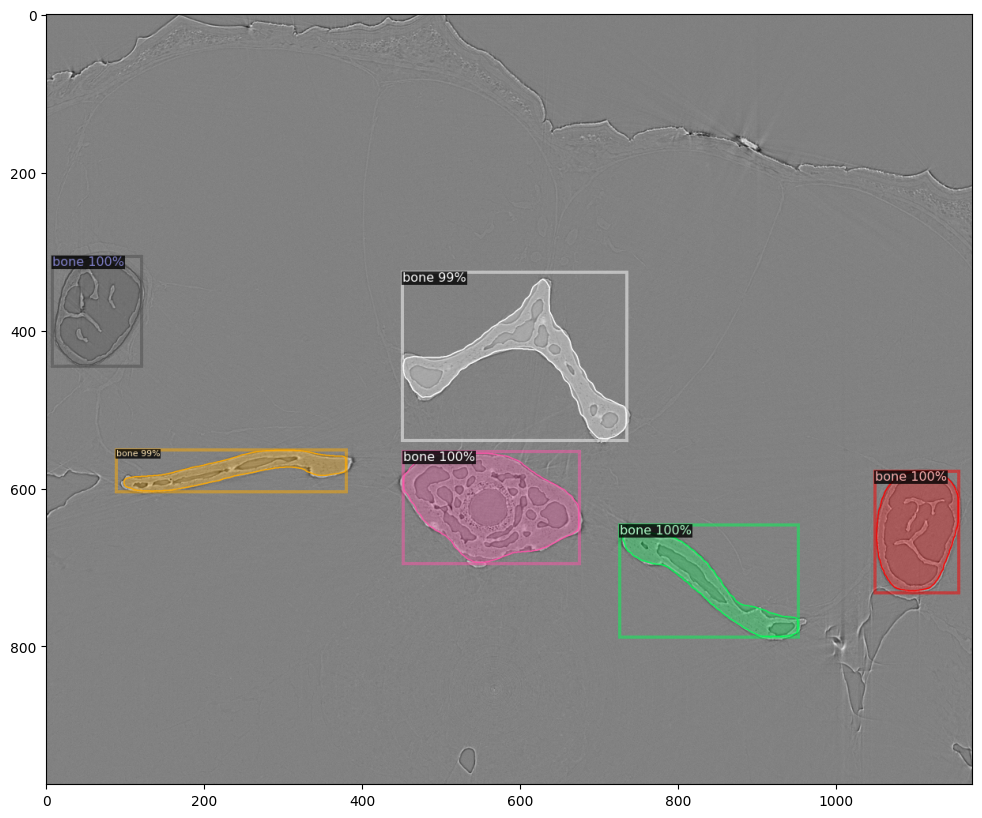

In [10]:

dataset_dicts = DatasetCatalog.get(val_dataset_name)

_, ax = plt.subplots(figsize=(15, 10))
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=wagon_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image()[:, :, ::-1])

We can also evaluate its performance using AP metric implemented in COCO API.

In [11]:

evaluator = COCOEvaluator(val_dataset_name, output_dir="./output")
val_loader = build_detection_test_loader(cfg, val_dataset_name)
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[09/11 01:37:34 d2.data.datasets.coco]: Loaded 20 images in COCO format from dataset/val.json
[09/11 01:37:34 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    bone    | 112          |
|            |              |
[09/11 01:37:34 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[09/11 01:37:34 d2.data.common]: Serializing 20 elements to byte tensors and concatenating them all ...
[09/11 01:37:34 d2.data.common]: Serialized dataset takes 0.02 MiB
[09/11 01:37:34 d2.evaluation.evaluator]: Start inference on 20 batches
[09/11 01:37:39 d2.evaluation.evaluator]: Inference done 11/20. Dataloading: 0.0008 s/iter. Inference: 0.1985 s/iter. Eval: 0.0902 s/iter. Total: 0.2896 s/iter. ETA=0:00:02
[09/11 01:37:42 d2.evaluation.evaluator]: Total inference time: 0:00:04.416067 (0.294404 s / iter per device,